# Implement multiclass classification on the Iris dataset

## 1. Import Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import preprocessing and model modules
from data_preprocessing import DataLoader, DataPreprocessor, create_pipeline
from models import MulticlassClassifier, ModelTrainer, HyperparameterTuner
from evaluation import ClassificationEvaluator, print_evaluation_summary
from feature_engineering import FeatureSelector, DimensionalityReducer

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## 2. Load and Explore Data

In [3]:
# Load dataset
loader = DataLoader()
df = loader.load_sklearn_dataset('iris', save_raw=True)

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:\n{df.head()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nClass distribution:\n{df['target'].value_counts()}")

Dataset saved to C:\Users\nobu\PyCharmMiscProject\data\raw\iris.csv
Dataset shape: (150, 5)

First few rows:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  

Data types:
sepal length (cm)    float64
sepal width (cm)     float64
petal length (cm)    float64
petal width (cm)     float64
target                 int64
dtype: object

Class distribution:
target
0    50
1    50
2    50
Name: count, dtype: int64


## 3. Data Preprocessing

In [4]:
# Create preprocessing pipeline
X_train, X_test, y_train, y_test, preprocessor = create_pipeline(
    df,
    target_column='target',
    handle_missing=True,
    missing_strategy='mean',
    encode_categorical=True,
    scale_features=True,
    scaling_method='standard',
    remove_outliers=False,
    test_size=0.2,
    random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nClass distribution in training set:\n{pd.Series(y_train).value_counts().sort_index()}")

Training set shape: (120, 4)
Test set shape: (30, 4)

Class distribution in training set:
target
0    40
1    40
2    40
Name: count, dtype: int64


## 4. Featyre Engineering

In [5]:
# Feature selection
selector = FeatureSelector()
X_train_selected, selected_features = selector.select_k_best(
    X_train, y_train, k=3
)
X_test_selected = X_test[:, selector.selector.get_support()]

print(f"Original features: {X_train.shape[1]}")
print(f"Selected features: {len(selected_features)}")
print(f"Feature names: {selected_features}")

Original features: 4
Selected features: 3
Feature names: ['Feature_0', 'Feature_2', 'Feature_3']


## 5. Train Multiclass Models

In [6]:
# Train multiple multiclass models
trainer = ModelTrainer(random_state=42)

model_configs = {
    'Random Forest': {
        'model_type': 'random_forest',
        'n_estimators': 100,
        'max_depth': 10
    },
    'Gradient Boosting': {
        'model_type': 'gradient_boosting',
        'n_estimators': 100,
        'learning_rate': 0.1
    },
    'Logistic Regression': {
        'model_type': 'logistic_regression',
        'max_iter': 1000
    },
    'KNN': {
        'model_type': 'knn',
        'n_neighbors': 5
    }
}

trained_models = trainer.train_multiple_models(X_train, y_train, model_configs)

print(f"Successfully trained {len(trained_models)} models")
for model_name in trained_models.keys():
    print(f"  ✓ {model_name}")

Training Random Forest...
Training Gradient Boosting...
Training Logistic Regression...
Training KNN...
Successfully trained 4 models
  ✓ Random Forest
  ✓ Gradient Boosting
  ✓ Logistic Regression
  ✓ KNN


## 5. Hyperparameter Tuning

In [7]:
# Tune Random Forest hyperparameters
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

tuner = HyperparameterTuner(
    rf_model,
    param_grid,
    cv=5,
    scoring='accuracy',
    random_state=42
)

print("Performing grid search...")
best_rf_model = tuner.grid_search(X_train, y_train, n_jobs=-1)

print(f"\nBest parameters: {tuner.get_best_params()}")
print(f"Best CV score: {tuner.get_best_score():.4f}")

Performing grid search...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score: 0.9583


## 7. Model Evaluation

In [8]:
# Evaluate best model on test set
evaluator = ClassificationEvaluator(model_name='Tuned Random Forest')

y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)

metrics = evaluator.evaluate(y_test, y_pred, y_pred_proba, average='weighted')

print("Test Set Metrics:")
print("-" * 40)
for metric_name, value in metrics.items():
    print(f"  {metric_name:20s}: {value:.4f}")

Test Set Metrics:
----------------------------------------
  accuracy            : 0.9667
  precision           : 0.9697
  recall              : 0.9667
  f1_score            : 0.9666
  matthews_corrcoef   : 0.9516
  cohen_kappa         : 0.9500
  roc_auc             : 0.9933
  log_loss            : 0.1242


## 8. Visualization - Confusion Matrix

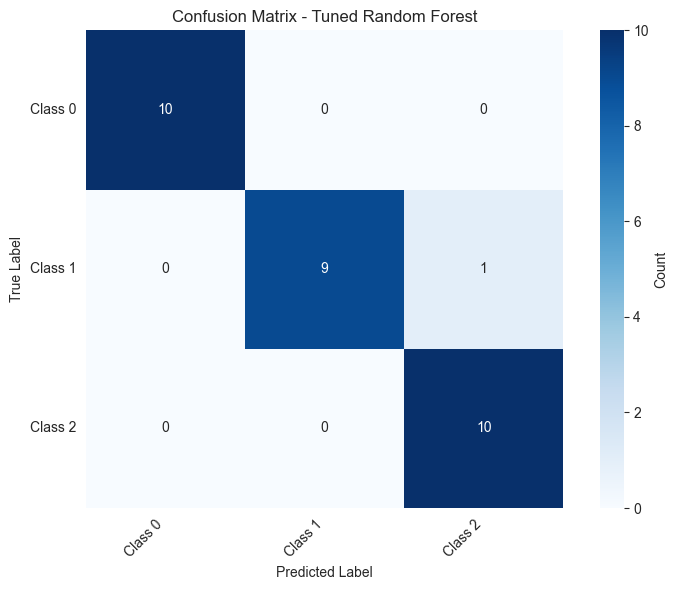

In [9]:
# Plot confusion matrix
fig = evaluator.plot_confusion_matrix(
    y_test,
    y_pred,
    class_names=['Class 0', 'Class 1', 'Class 2'],
    normalize=False,
    figsize=(8, 6)
)
plt.show()

## 9. Visualization - Classification Report

In [10]:
# Print detailed classification report
print_evaluation_summary(
    y_test,
    y_pred,
    y_pred_proba,
    model_name='Tuned Random Forest',
    class_names=['Class 0', 'Class 1', 'Class 2']
)


Evaluation Summary: Tuned Random Forest

Overall Metrics:
----------------------------------------
  accuracy            : 0.9667
  precision           : 0.9697
  recall              : 0.9667
  f1_score            : 0.9666
  matthews_corrcoef   : 0.9516
  cohen_kappa         : 0.9500
  roc_auc             : 0.9933
  log_loss            : 0.1242

Classification Report:
----------------------------------------
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        10
     Class 1       1.00      0.90      0.95        10
     Class 2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Confusion Matrix:
----------------------------------------
[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]




## 10. Compare All Models

In [11]:
# Compare all trained models
from src.evaluation import compare_models

comparison_results = compare_models(
    trained_models,
    X_test,
    y_test,
    average='weighted'
)

print("\nModel Comparison Results:")
print("=" * 60)
print(comparison_results)


Model Comparison Results:
                     accuracy  precision    recall  f1_score  \
Gradient Boosting    0.966667   0.969697  0.966667  0.966583   
Logistic Regression  0.933333   0.933333  0.933333  0.933333   
KNN                  0.933333   0.944444  0.933333  0.932660   
Random Forest        0.900000   0.902357  0.900000  0.899749   

                     matthews_corrcoef  cohen_kappa   roc_auc  log_loss  
Gradient Boosting             0.951587         0.95  0.996667  0.174449  
Logistic Regression           0.900000         0.90  0.996667  0.173973  
KNN                           0.906061         0.90  0.993333  0.119607  
Random Forest                 0.851420         0.85  0.993333  0.120382  


## 11. Feature Importance


Feature Importance:
     feature  importance
0  Feature 3    0.443877
1  Feature 2    0.437184
2  Feature 0    0.110561
3  Feature 1    0.008378


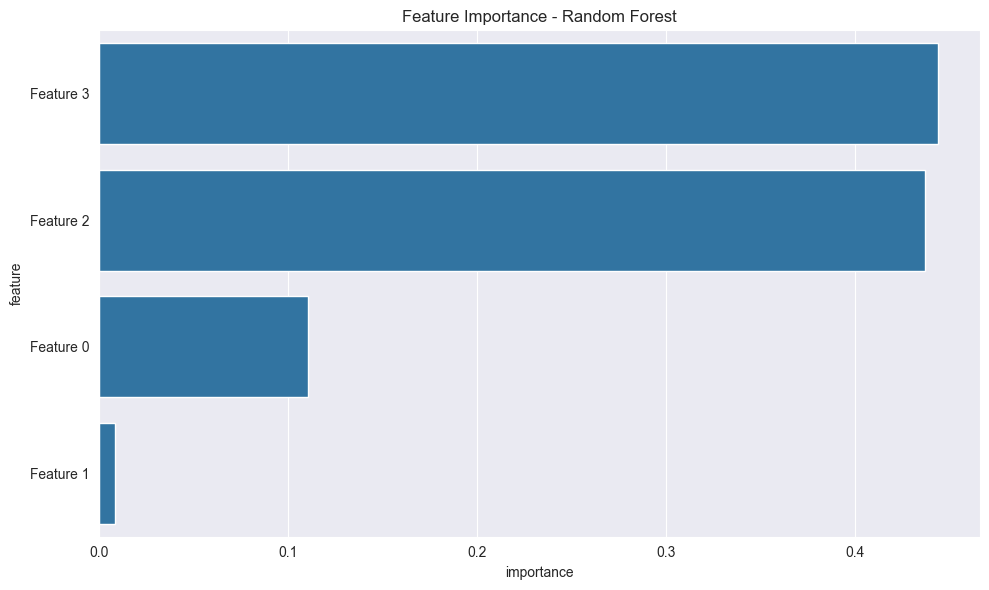

In [12]:
# Get feature importance from best model
from src.models import get_feature_importance

importance_df = get_feature_importance(
    best_rf_model,
    feature_names=['Feature 0', 'Feature 1', 'Feature 2', 'Feature 3']
)

print("\nFeature Importance:")
print(importance_df)

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature', ax=ax)
ax.set_title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

## 12. Save Best Model

In [13]:
# Save the best model
from src.models import save_model

save_model(best_rf_model, 'models/best_multiclass_model.pkl')
print("Model saved successfully!")

Model saved to models\best_multiclass_model.pkl
Model saved successfully!
